In [1]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.applications.inception_v3 import InceptionV3

from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

In [3]:

# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [5]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        images = images.astype('float32') / 255
        images_mean = np.mean(images, axis=0)
        images -= images_mean

        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.2)
train_df.shape, val_df.shape

((10858, 28), (2715, 28))

In [7]:
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [8]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'gender': 2,
 'image_quality': 3,
 'age': 5,
 'weight': 4,
 'bag': 3,
 'pose': 3,
 'footwear': 3,
 'emotion': 4}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 220, 220, 64)      0   

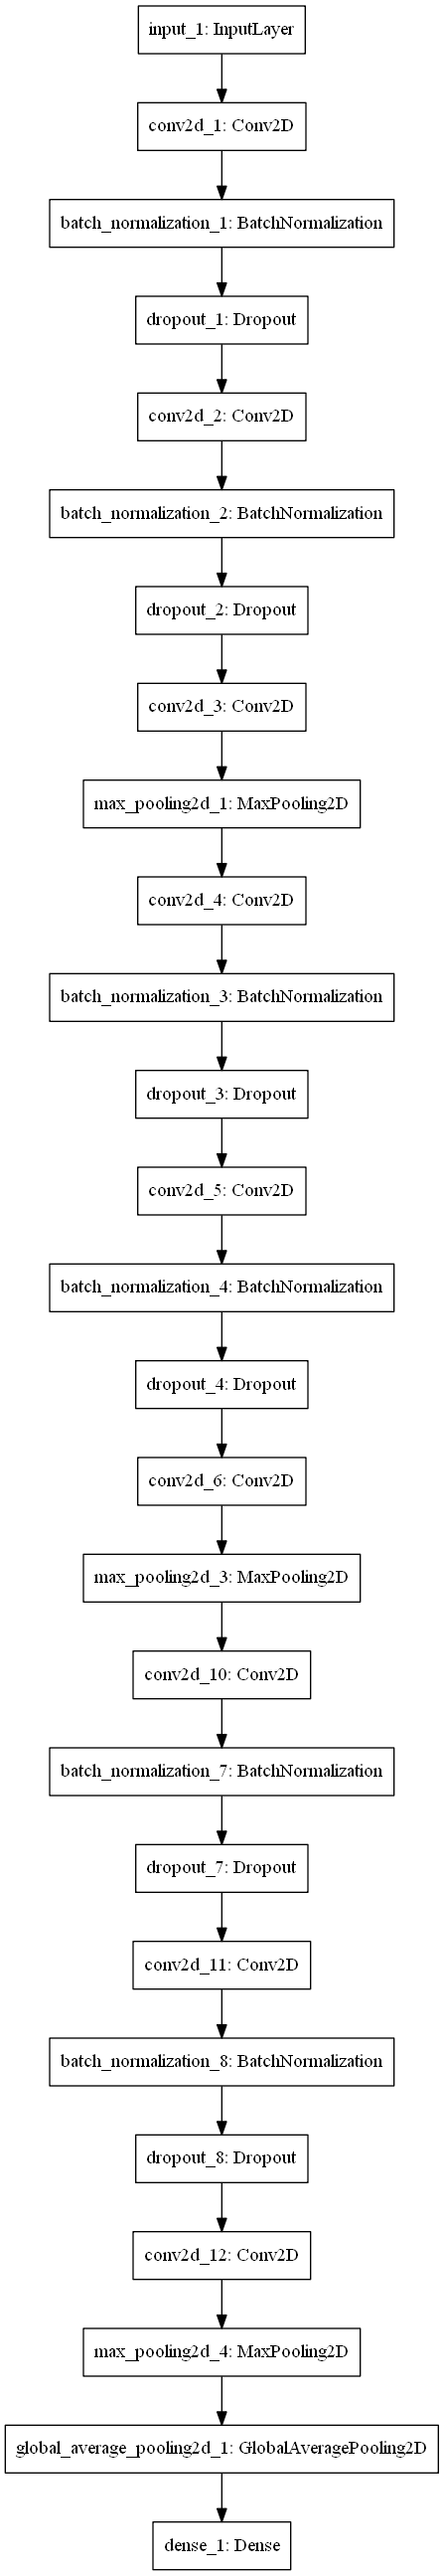

In [9]:

# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D,GlobalAveragePooling2D
sequential_Input = Input(shape=(224,224,3))

Sequential_NN1_1=Conv2D(32, kernel_size=3, activation='relu', use_bias=False)(sequential_Input)
Sequential_NN1_1_BN=BatchNormalization()(Sequential_NN1_1)
Sequential_NN1_1_DRP=Dropout(0.2)(Sequential_NN1_1_BN)
Sequential_NN1_2=Conv2D(64, kernel_size=3, activation='relu', use_bias=False)(Sequential_NN1_1_DRP)
Sequential_NN1_2_BN=BatchNormalization()(Sequential_NN1_2)
Sequential_NN1_2_DRP=Dropout(0.2)(Sequential_NN1_2_BN)
Sequential_NN1_3=Conv2D(32, kernel_size=1, activation='relu', use_bias=False)(Sequential_NN1_2_DRP)
Sequential_NN_pool1= MaxPooling2D()(Sequential_NN1_3)


Sequential_NN2_1=Conv2D(32, kernel_size=3, activation='relu', use_bias=False)(Sequential_NN_pool1)
Sequential_NN2_1_BN=BatchNormalization()(Sequential_NN2_1)
Sequential_NN2_1_DRP=Dropout(0.2)(Sequential_NN2_1_BN)
Sequential_NN2_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN2_1_DRP)
Sequential_NN2_2_BN=BatchNormalization()(Sequential_NN2_2)
Sequential_NN2_2_DRP=Dropout(0.2)(Sequential_NN2_2_BN)
Sequential_NN2_3=Conv2D(32, kernel_size=1, activation='relu', use_bias=False)(Sequential_NN2_2_DRP)
Sequential_NN_pool2= MaxPooling2D()(Sequential_NN2_3)



Sequential_NN3_1=Conv2D(32, kernel_size=3, activation='relu', use_bias=False)(Sequential_NN_pool2)
Sequential_NN3_1_BN=BatchNormalization()(Sequential_NN3_1)
Sequential_NN3_1_DRP=Dropout(0.1)(Sequential_NN3_1_BN)
Sequential_NN3_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN3_1_DRP)
Sequential_NN3_2_BN=BatchNormalization()(Sequential_NN3_2)
Sequential_NN3_2_DRP=Dropout(0.1)(Sequential_NN3_2_BN)
Sequential_NN3_3=Conv2D(32, kernel_size=1, activation='relu', use_bias=False)(Sequential_NN3_2_DRP)
Sequential_NN_pool3= MaxPooling2D()(Sequential_NN2_3)




Sequential_NN4_1=Conv2D(32, kernel_size=3, activation='relu', use_bias=False)(Sequential_NN_pool3)
Sequential_NN4_1_BN=BatchNormalization()(Sequential_NN4_1)
Sequential_NN4_1_DRP=Dropout(0.1)(Sequential_NN4_1_BN)
Sequential_NN4_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN4_1_DRP)
Sequential_NN4_2_BN=BatchNormalization()(Sequential_NN4_2)
Sequential_NN4_2_DRP=Dropout(0.1)(Sequential_NN4_2_BN)
Sequential_NN4_3=Conv2D(32, kernel_size=1, activation='relu', use_bias=False)(Sequential_NN4_2_DRP)
Sequential_NN_pool4= MaxPooling2D()(Sequential_NN4_3)


Sequential_NN_GAP=GlobalAveragePooling2D()(Sequential_NN_pool4)
Output=Dense(64, activation='softmax')(Sequential_NN_GAP)

backbone = Model(inputs=sequential_Input, outputs=Output)
print(backbone.summary())

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot graph
plot_model(backbone, to_file='convolutional_neural_network.png')


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 222, 222, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 222, 222, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

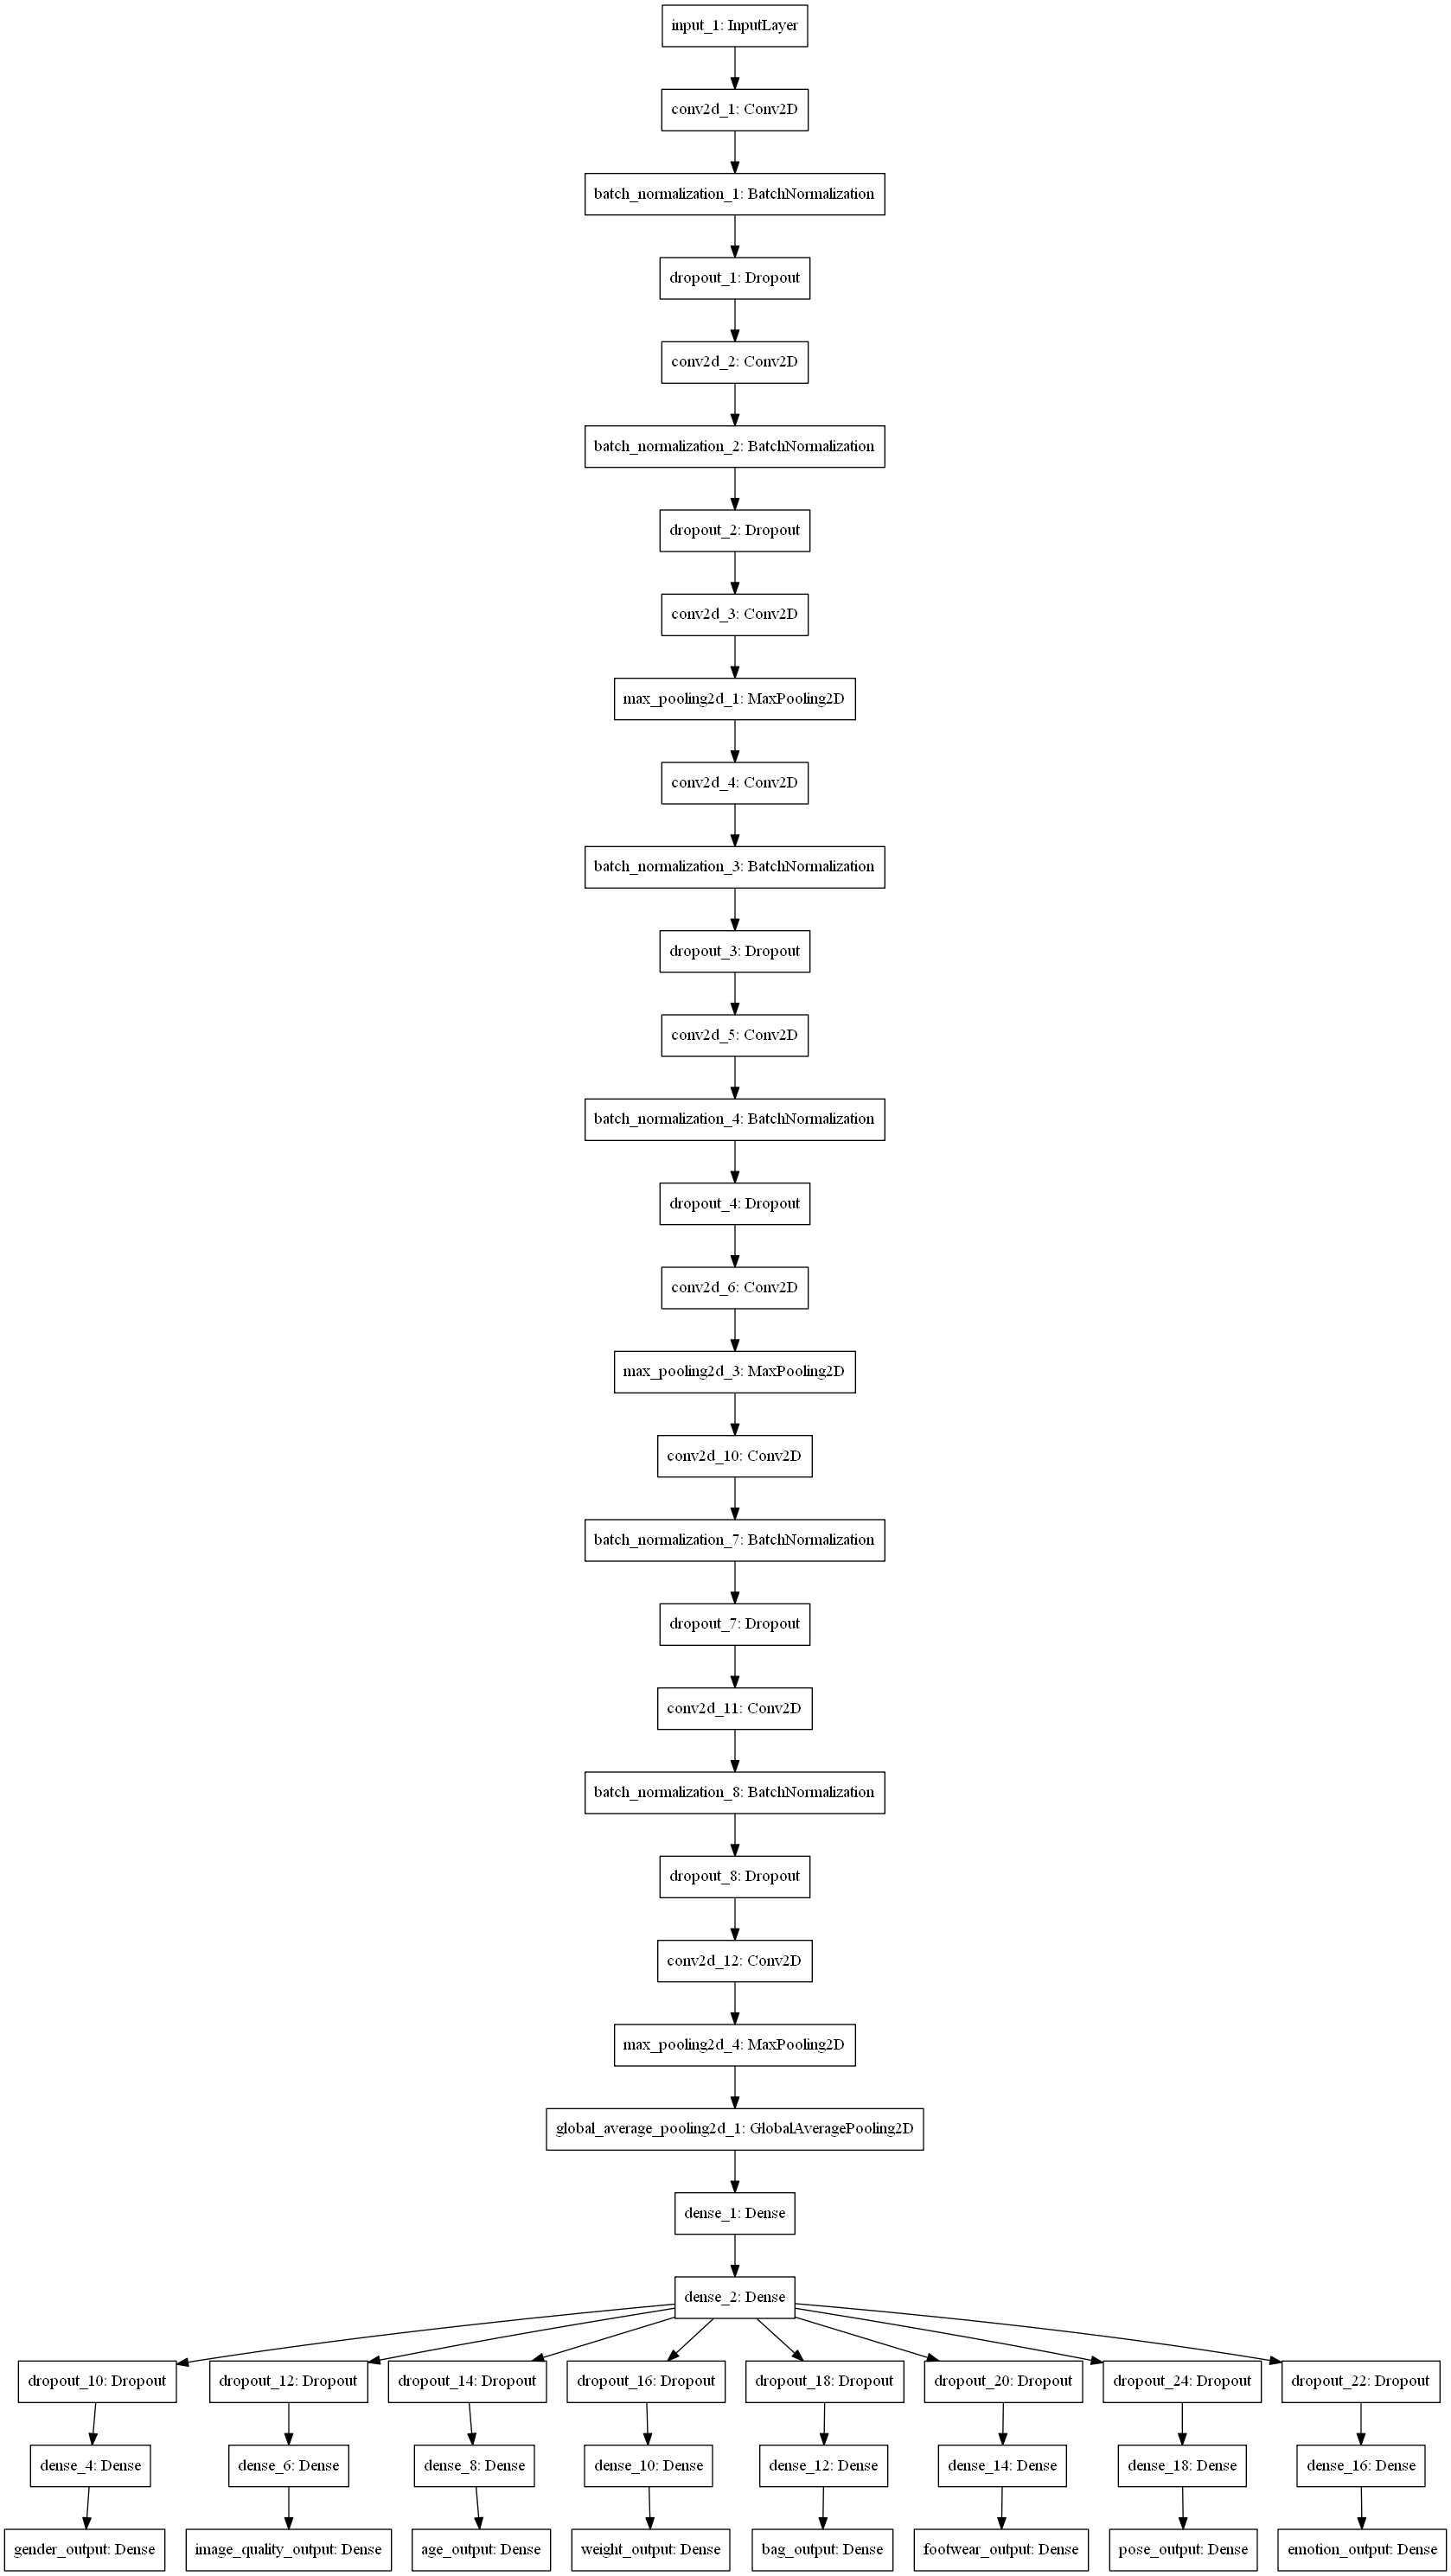

In [10]:
neck = backbone.output
neck = Dense(64, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

Dhruv_net = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

print(Dhruv_net.summary())

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot graph
plot_model(Dhruv_net, to_file='convolutional_neural_network.png')

In [11]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_type='Dhruv_Net v3'
model_name = 'customcnn_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [12]:
# Prepare callbacks for model saving and for learning rate adjustment.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath=filepath,
                             #monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

In [13]:
losses = {
"gender_output": "binary_crossentropy",
"image_quality_output": "categorical_crossentropy",
"age_output": "categorical_crossentropy",
"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy"

}

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(lr * 1/(1 + 0.023 * epoch), 10)

loss_weights = {"gender_output": 0.8, "image_quality_output": 0.8, "age_output": 0.6, "weight_output": 0.97, "bag_output": 0.8 ,"pose_output": 0.9,
  "footwear_output": 0.7,
  "emotion_output": 0.98}
 #loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = optimizer=Adam(lr=0.2)

Dhruv_net.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [14]:
callbacks=[LearningRateScheduler(scheduler, verbose=1),checkpoint]

In [ ]:
Dhruv_net.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.200000003.
339/339 [==============================] - 7460s 22s/step - loss: 11.4115 - gender_output_loss: 6.6964 - image_quality_output_loss: 1.0300 - age_output_loss: 1.4668 - weight_output_loss: 1.0229 - bag_output_loss: 0.9647 - footwear_output_loss: 1.0810 - pose_output_loss: 0.9756 - emotion_output_loss: 0.9710 - gender_output_accuracy: 0.5631 - image_quality_output_accuracy: 0.5483 - age_output_accuracy: 0.3965 - weight_output_accuracy: 0.6312 - bag_output_accuracy: 0.5603 - footwear_output_accuracy: 0.4332 - pose_output_accuracy: 0.6143 - emotion_output_accuracy: 0.7075 - val_loss: 10.8724 - val_gender_output_loss: 6.7741 - val_image_quality_output_loss: 0.9764 - val_age_output_loss: 1.4441 - val_weight_output_loss: 0.9661 - val_bag_output_loss: 0.9396 - val_footwear_output_loss: 1.0343 - val_pose_output_loss: 0.9253 - val_emotion_output_loss: 0.9227 - val_gender_output_accuracy: 0.5595 - val_image_qualit